# Archetype analysis on Harmony data

In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
import mazebox as mb
import cellrank as cr
import scanorama
from scipy.spatial.distance import squareform
from scipy.sparse import issparse, csr_matrix, find
from scipy.spatial.distance import pdist
from py_pcha import PCHA
from sklearn.utils import shuffle
from matplotlib.colors import CenteredNorm

In [10]:
adata = sc.read_h5ad('../../data/combined/adata_02_filtered.h5ad')

In [6]:
x_harmony = pd.read_csv('./ParetoTI/x_harmony2.csv', index_col = 0)

In [14]:
adata.obsm['X_pca'].shape

(8908, 50)

In [20]:
x_harmony = x_harmony.T

In [29]:
harmony_indices = []
for i, r in adata.obs.iterrows():
    adata_label = i.split(':')[1][:-4]+"-" + i.split("-")[1][1]
    if adata_label in x_harmony.index:
        harmony_indices.append(adata_label)
        

In [32]:
x_harmony = x_harmony.loc[harmony_indices]

In [33]:
adata.obsm['X_harmony2'] = np.array(x_harmony)

In [122]:
def find_knee(ev_per_arc, kmax):
    farthestk = 0
    for i in range(3,kmax):
        #find distance of point p3 from line between p1 and p2
        p1=np.array([3,ev_per_arc[0]])
        p2=np.array([kmax,ev_per_arc[kmax-3]])
        p3=np.array([i,ev_per_arc[i-3]])
        k = (np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))

        #knee is farthest away from line between p1 and p2
        if k > farthestk: 
            farthestk = k
            knee = i
    print("K* =",knee, "archetypes, distance between k* and line: ",np.round(farthestk,2))
    return knee, farthestk

0.7605763484666126
0.8232217321520273
0.8969114856172292
0.9520221002564798
0.9842655548888386
0.9889835550810158
0.9912551197175844
0.9930173517767531
Knee in EV vs k plot for different k_max:
k_max = 8
K* = 6 archetypes, distance between k* and line:  0.05
k_max = 9
K* = 6 archetypes, distance between k* and line:  0.08
k_max = 10
K* = 6 archetypes, distance between k* and line:  0.09


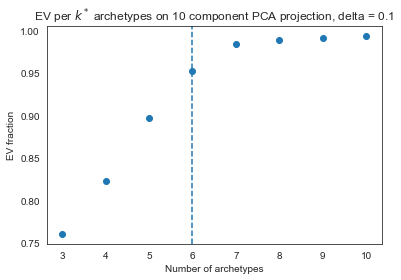

In [123]:
ev_per_arc = []
for i in range(3,11):
    XC, S, C, SSE, varexpl = PCHA(adata.obsm['X_harmony2'][:,0:7].T, noc=i, delta=0.1)
    ev_per_arc.append(varexpl)
    print(varexpl)
plt.scatter(x = [3,4,5,6,7,8,9,10], y = ev_per_arc)
plt.title(f"EV per $k^*$ archetypes on 10 component PCA projection, delta = 0.1")
plt.xlabel("Number of archetypes")
plt.ylabel("EV fraction")
print("Knee in EV vs k plot for different k_max:")
for kmax in range(8,11):
    print('k_max =', kmax)
    knee, farthestk = find_knee(ev_per_arc, kmax=kmax)
plt.axvline(x=knee, linestyle = "--")
plt.show()

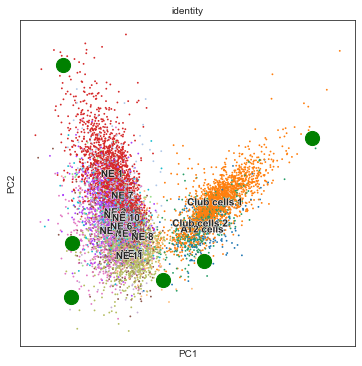

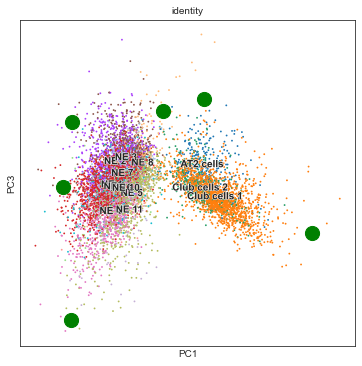

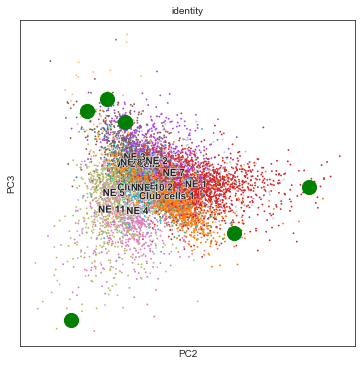

In [39]:
XC, S, C, SSE, varexpl = PCHA(adata.obsm['X_harmony2'][:,0:7].T, noc=6, delta=0)
XC = np.array(XC)
for components in ['1,2','1,3','2,3']:
    scv.pl.scatter(adata, color = 'identity', basis = 'harmony2', components=components, show=False, figsize= (6,6), frameon=True)
    comp = components.split(',')
    plt.scatter(XC[int(comp[0])-1], XC[int(comp[1])-1], color = 'green', s = 200)
    plt.xlabel("PC"+comp[0])
    plt.ylabel("PC"+comp[1])

    plt.show()

## Labeling cells based on diffusion distance to archetypes
From Van Dijk et al:
An archetype is a weighted sum of cells, which allows us to construct archetypal-neighborhoods, consisting of cells most similar to the archetype. The neighborhoods are constructed by assigning cells to their nearest archetype based on the diffusion distance, as long as this distance is within a bounded proximity from the archetype. Diffusion distance is defined as the Euclidean distance on the diffusion map representation of the data, i.e., using diffusion components as a coordinate system (Nadler et al., 2006), denoted by DM(t).

In [76]:
XC_df = pd.DataFrame(XC)
XC_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5', "Arc_6"]


In [80]:
adata_pca_df = pd.DataFrame(adata.obsm['X_harmony2'][:,0:7], index = adata.obs_names)
adata_full_df = adata_pca_df.append(XC_df.T)
adata_full_df.head()

0         1         2  \
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1 -10.853421  3.314483 -1.955959   
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1 -16.172503  1.581542 -2.973032   
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  25.159592  1.506365 -1.755977   
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1 -13.424174 -6.007257 -1.668134   
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1 -14.884157  0.732516  8.161187   

                                                     3          4         5  \
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  0.342224   0.055966 -1.801487   
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  0.684828   0.715530 -0.983584   
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1 -0.670800   1.210627 -1.516556   
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  1.563288   0.169113 -0.828716   
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  5.240258 -13.670139  7.955088   

                                                     6  
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1 -1.821602  
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1 -1.349162  
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1 -4.102429  
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1 -2.283996  
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1 -2.024470

In [81]:
adata_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914 entries, gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1 to Arc_6
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8914 non-null   float64
 1   1       8914 non-null   float64
 2   2       8914 non-null   float64
 3   3       8914 non-null   float64
 4   4       8914 non-null   float64
 5   5       8914 non-null   float64
 6   6       8914 non-null   float64
dtypes: float64(7)
memory usage: 557.1+ KB


In [82]:
pdx = squareform(pdist(adata_full_df, metric='euclidean')) # compute distances on pca
pdx_df = pd.DataFrame(pdx, index=adata_full_df.index, columns=adata_full_df.index)
pdx_df = pdx_df.loc[XC_df.columns].drop(XC_df.columns, axis = 1)
adata.obsm['arc_distance'] = pdx_df.T

In [83]:
pdx_df

gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  \
Arc_1                                     32.920406   
Arc_2                                     57.946935   
Arc_3                                     40.410183   
Arc_4                                     68.311453   
Arc_5                                     33.851056   
Arc_6                                     27.413544   

       gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  \
Arc_1                                     35.651534   
Arc_2                                     61.309113   
Arc_3                                     39.162418   
Arc_4                                     73.549151   
Arc_5                                     30.558236   
Arc_6                                     26.218745   

       gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  \
Arc_1                                     31.824145   
Arc_2                                     50.091979   
Arc_3                                     62.605478   
Arc_4                                     34.759745   
Arc_5                                     57.934403   
Arc_6                                     57.188770   

       gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  \
Arc_1                                     31.427225   
Arc_2                                     58.931994   
Arc_3                                     38.049539   
Arc_4                                     72.524522   
Arc_5                                     29.461296   
Arc_6                                     34.169073   

       gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  \
Arc_1                                     39.608729   
Arc_2                                     66.272576   
Arc_3                                     20.687697   
Arc_4                                     75.125028   
Arc_5                                     42.472863   
Arc_6                                     35.503918   

       gex_possorted_bam_SJSO3:AAACCGGCACCTCACCx-M1  \
Arc_1                                     22.033798   
Arc_2                                     44.701964   
Arc_3                                     43.255845   
Arc_4                                     66.028527   
Arc_5                                     42.582223   
Arc_6                                     42.925512   

       gex_possorted_bam_SJSO3:AAAGGAGCATCCTGAAx-M1  \
Arc_1                                     29.657892   
Arc_2                                     56.140748   
Arc_3                                     44.238077   
Arc_4                                     59.571861   
Arc_5                                     42.632044   
Arc_6                                     30.049069   

       gex_possorted_bam_SJSO3:AAAGCACCAACAGGATx-M1  \
Arc_1                                     28.275850   
Arc_2                                     58.474732   
Arc_3                                     32.135954   
Arc_4                                     63.196060   
Arc_5                                     44.933460   
Arc_6                                     39.265947   

       gex_possorted_bam_SJSO3:AAAGGACGTTACGCGGx-M1  \
Arc_1                                     30.338415   
Arc_2                                     45.615408   
Arc_3                                     54.040629   
Arc_4                                     44.133225   
Arc_5                                     54.316312   
Arc_6                                     53.432629   

       gex_possorted_bam_SJSO3:AAACGCGCAACACCTAx-M1  ...  \
Arc_1                                     29.982985  ...   
Arc_2                                     54.158689  ...   
Arc_3                                     37.147090  ...   
Arc_4                                     68.637199  ...   
Arc_5                                     34.661657  ...   
Arc_6                                     34.288970  ...   

       gex_possorted_bam_1WGCZ:TTTGCGGAGGTCGATTx-M2  \
Arc_1                                     24.071077   
Ar

In [84]:
pdx_archetypes = squareform(pdist(XC_df.T, metric='euclidean')) # compute distances on pca

radius = .5*pdx_archetypes[pdx_archetypes > 0].min()

In [105]:
radius

24.275198215339728

In [85]:
tmp = adata.obsm['arc_distance'].copy()

In [86]:
# percent_radius = .1 # in percentage of datapoints; radius = .1 means 10% closest cells to each archetype

for arc in  adata.obsm['arc_distance'].columns:
    closest = adata.obsm['arc_distance'].loc[adata.obsm['arc_distance'][arc].sort_values() < radius]
    tmp.loc[closest.index,'specialist'] = arc


In [87]:
tmp.specialist

gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1      NaN
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1      NaN
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1      NaN
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1      NaN
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1    Arc_3
                                                ...  
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2      NaN
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2      NaN
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2      NaN
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2      NaN
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2      NaN
Name: specialist, Length: 8908, dtype: object

In [88]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8908 entries, gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1 to gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Arc_1       8908 non-null   float64
 1   Arc_2       8908 non-null   float64
 2   Arc_3       8908 non-null   float64
 3   Arc_4       8908 non-null   float64
 4   Arc_5       8908 non-null   float64
 5   Arc_6       8908 non-null   float64
 6   specialist  2865 non-null   object 
dtypes: float64(6), object(1)
memory usage: 814.8+ KB


In [89]:
adata.obs['specialists_pca_diffdist'] = tmp.specialist

## Labeling by PCHA

<AxesSubplot:title={'center':'identity'}, xlabel='harmony21', ylabel='harmony22'>

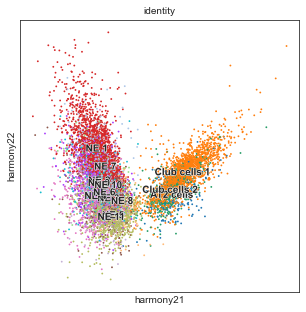

In [92]:
scv.pl.scatter(adata,basis = 'harmony2', c = 'identity', components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu')


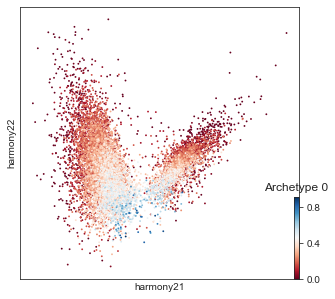

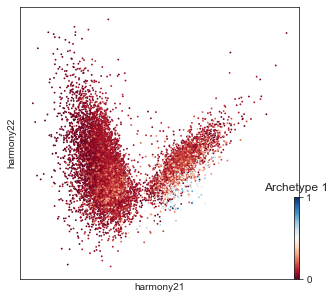

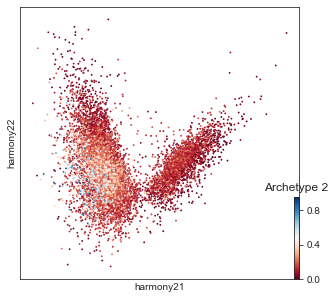

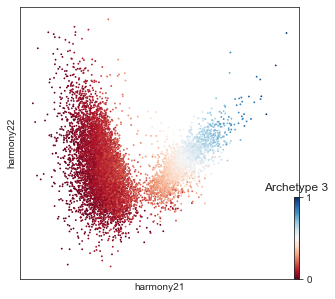

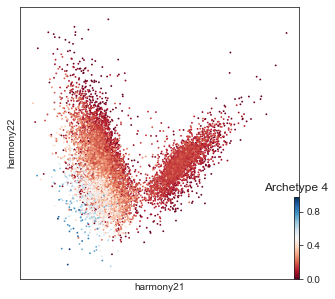

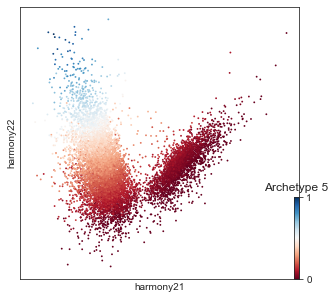

In [93]:
for i in range(6):
    scv.pl.scatter(adata, basis = 'harmony2',c = [S[i,:].T], components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu')
    plt.title(f"Archetype {i}")
    # plt.savefig(f'./figures/unsupervised_AA_magic/{i}_scPCHA_pca.pdf')
    

In [94]:
S_df = pd.DataFrame(S.T)

In [95]:
S_df.index = adata.obs_names

In [96]:
adata.obsm['py_pcha_S'] = S.T

In [97]:
adata

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

In [98]:
adata

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

In [99]:
adata.obsm['arc_distance'] = pdx_df.T

In [100]:
S_df.columns = ['Arc_1','Arc_2','Arc_3','Arc_4','Arc_5', 'Arc_6']

<AxesSubplot:ylabel='Count'>

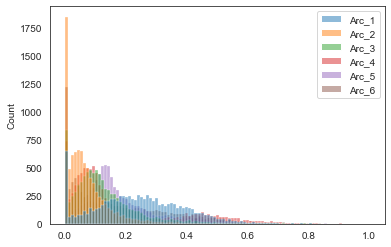

In [125]:
sns.histplot(S_df)

In [130]:
S_df > .5

Arc_1  Arc_2  Arc_3  Arc_4  \
CellID                                                                     
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  False  False  False  False   
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  False  False  False  False   
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  False  False  False  False   
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  False  False  False  False   
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  False  False   True  False   
...                                             ...    ...    ...    ...   
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2  False  False  False  False   
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2  False  False  False  False   
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2  False  False  False  False   
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2  False  False  False  False   
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2  False  False  False  False   

                                              Arc_5  Arc_6  
CellID                                                      
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  False  False  
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  False  False  
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  False  False  
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  False  False  
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  False  False  
...                                             ...    ...  
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2  False  False  
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2  False  False  
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2  False  False  
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2  False  False  
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2  False  False  

[8908 rows x 6 columns]

In [131]:
max_arc = (S_df > .5).idxmax(axis=1)

In [132]:
for i,r in S_df.iterrows():
    if r.max() < 0.5:
        max_arc[i] = 'Generalist'

In [137]:
adata.obs['S_0.5threshold'] = max_arc

In [143]:
adata.uns['S_0.5threshold_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b','#D3D3D3']

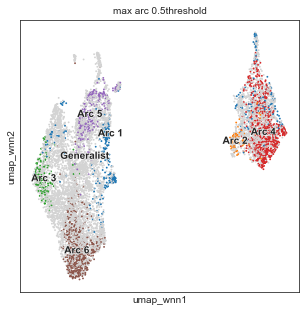

In [144]:
scv.pl.scatter(adata, c = 'S_0.5threshold', basis = "umap_wnn", figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)


In [145]:
max_arc = (S_df > .6).idxmax(axis=1)

for i,r in S_df.iterrows():
    if r.max() < 0.6:
        max_arc[i] = 'Generalist'

adata.obs['S_0.6threshold'] = max_arc

adata.uns['S_0.6threshold_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b','#D3D3D3']

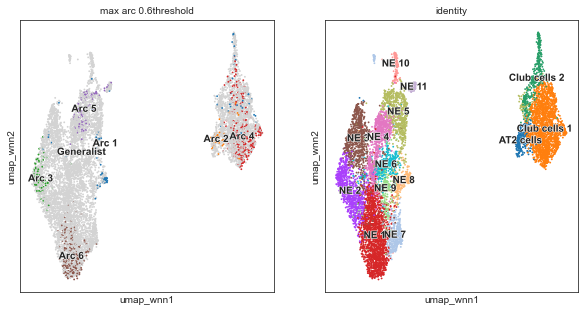

In [147]:
scv.pl.scatter(adata, c = ['S _0.6threshold','identity'], basis = "umap_wnn", figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)


In [101]:
adata.obsm['py_pcha_S'] = S_df

In [102]:
for c in adata.obsm['py_pcha_S']:
    adata.obs[f"{c}_PCHA_Score"] = adata.obsm['py_pcha_S'][c]

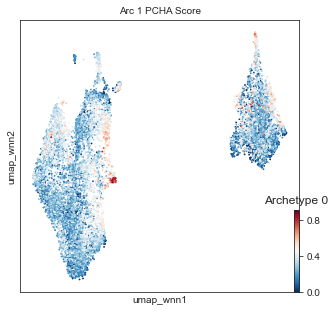

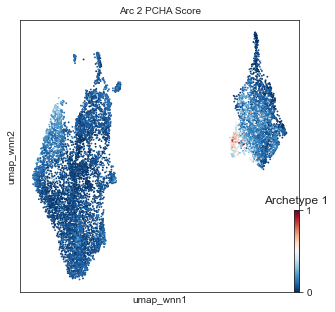

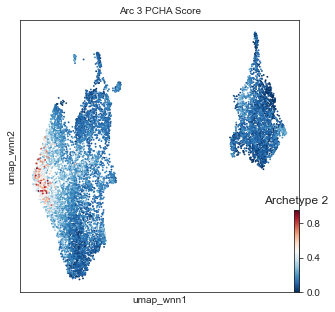

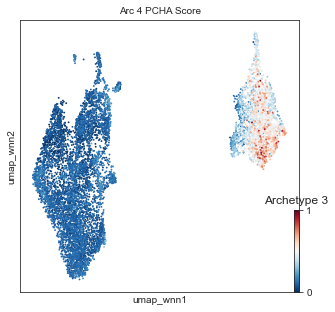

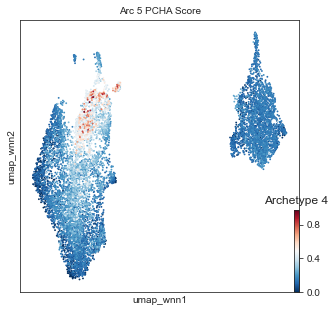

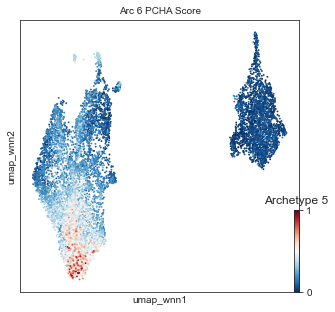

In [354]:
for i in range(6):
    scv.pl.scatter(adata, c = f"Arc_{str(i+1)}_PCHA_Score", basis = "umap_wnn",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = False)
    plt.title(f"Archetype {i}")
    plt.show()

<AxesSubplot:title={'center':'specialists pca diffdist'}, xlabel='umap_wnn1', ylabel='umap_wnn2'>

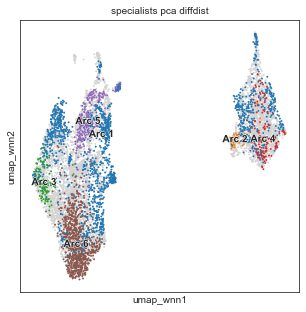

In [104]:
scv.pl.scatter(adata, c = 'specialists_pca_diffdist', basis = "umap_wnn",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)


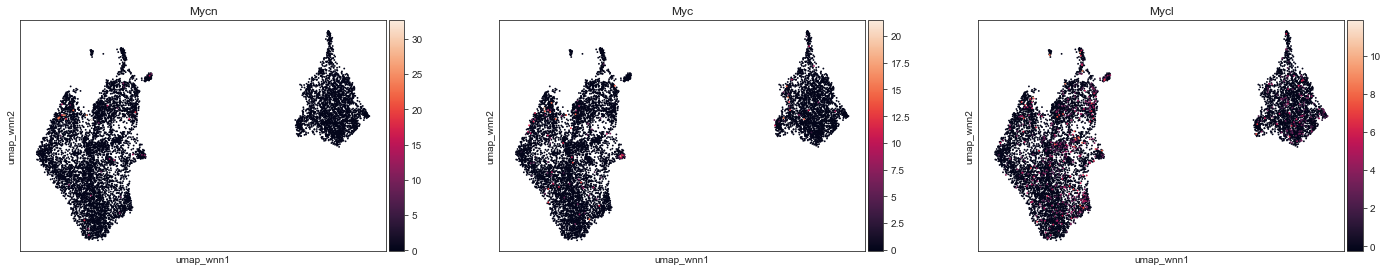

In [115]:
sc.pl.scatter(adata, color = ['Mycn','Myc','Mycl'], basis = 'umap_wnn')


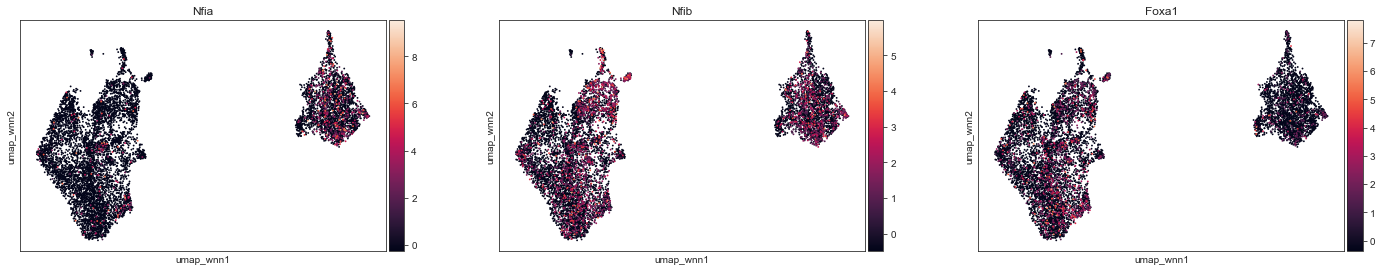

In [119]:
sc.pl.scatter(adata, color = ['Nfia','Nfib', "Foxa1"], basis = 'umap_wnn')


In [120]:
adata

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

In [153]:
adata.write_h5ad('../../data/combined/adata_02_filtered.h5ad')

## Archetype Distances

In [155]:
pdx_df

gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  \
Arc_1                                     32.920406   
Arc_2                                     57.946935   
Arc_3                                     40.410183   
Arc_4                                     68.311453   
Arc_5                                     33.851056   
Arc_6                                     27.413544   

       gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  \
Arc_1                                     35.651534   
Arc_2                                     61.309113   
Arc_3                                     39.162418   
Arc_4                                     73.549151   
Arc_5                                     30.558236   
Arc_6                                     26.218745   

       gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  \
Arc_1                                     31.824145   
Arc_2                                     50.091979   
Arc_3                                     62.605478   
Arc_4                                     34.759745   
Arc_5                                     57.934403   
Arc_6                                     57.188770   

       gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  \
Arc_1                                     31.427225   
Arc_2                                     58.931994   
Arc_3                                     38.049539   
Arc_4                                     72.524522   
Arc_5                                     29.461296   
Arc_6                                     34.169073   

       gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  \
Arc_1                                     39.608729   
Arc_2                                     66.272576   
Arc_3                                     20.687697   
Arc_4                                     75.125028   
Arc_5                                     42.472863   
Arc_6                                     35.503918   

       gex_possorted_bam_SJSO3:AAACCGGCACCTCACCx-M1  \
Arc_1                                     22.033798   
Arc_2                                     44.701964   
Arc_3                                     43.255845   
Arc_4                                     66.028527   
Arc_5                                     42.582223   
Arc_6                                     42.925512   

       gex_possorted_bam_SJSO3:AAAGGAGCATCCTGAAx-M1  \
Arc_1                                     29.657892   
Arc_2                                     56.140748   
Arc_3                                     44.238077   
Arc_4                                     59.571861   
Arc_5                                     42.632044   
Arc_6                                     30.049069   

       gex_possorted_bam_SJSO3:AAAGCACCAACAGGATx-M1  \
Arc_1                                     28.275850   
Arc_2                                     58.474732   
Arc_3                                     32.135954   
Arc_4                                     63.196060   
Arc_5                                     44.933460   
Arc_6                                     39.265947   

       gex_possorted_bam_SJSO3:AAAGGACGTTACGCGGx-M1  \
Arc_1                                     30.338415   
Arc_2                                     45.615408   
Arc_3                                     54.040629   
Arc_4                                     44.133225   
Arc_5                                     54.316312   
Arc_6                                     53.432629   

       gex_possorted_bam_SJSO3:AAACGCGCAACACCTAx-M1  ...  \
Arc_1                                     29.982985  ...   
Arc_2                                     54.158689  ...   
Arc_3                                     37.147090  ...   
Arc_4                                     68.637199  ...   
Arc_5                                     34.661657  ...   
Arc_6                                     34.288970  ...   

       gex_possorted_bam_1WGCZ:TTTGCGGAGGTCGATTx-M2  \
Arc_1                                     24.071077   
Ar

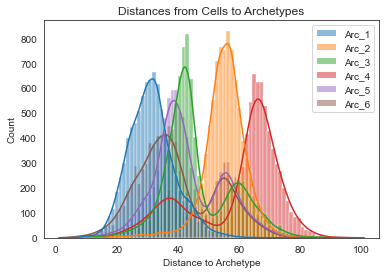

In [170]:
sns.histplot(pdx_df.T, kde = True, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.title("Distances from Cells to Archetypes")
plt.xlabel("Distance to Archetype")
plt.show()

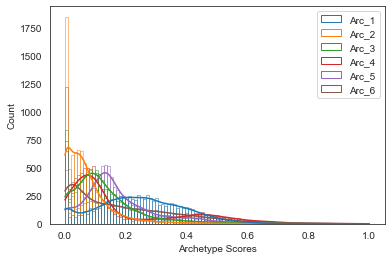

In [197]:
g = sns.histplot(S_df, fill=False,kde = True, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
# g.axes.set_yscale('log')
plt.xlabel("Archetype Scores")
plt.show()

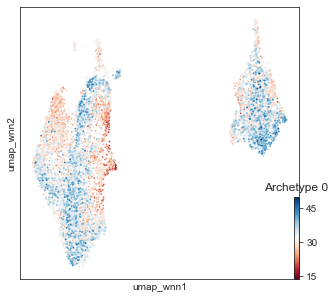

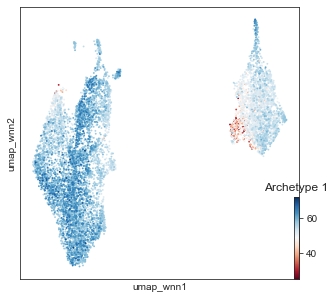

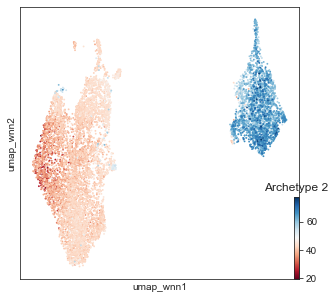

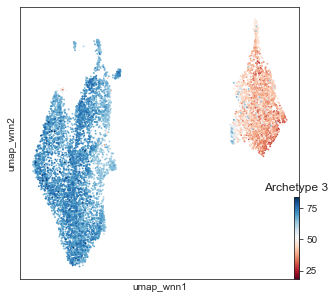

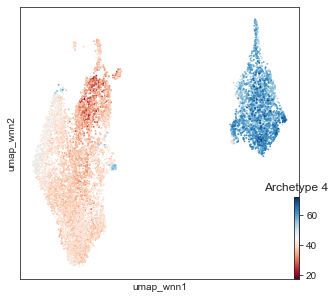

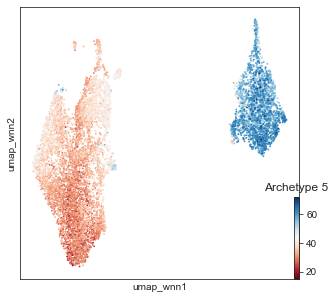

In [356]:
for i in range(6):
    scv.pl.scatter(adata, c = pdx_df.loc["Arc_"+str(i+1)].T, basis = "umap_wnn",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu', smooth = True)
    plt.title(f"Archetype {i}")
    plt.show()

In [175]:
S_df

Arc_1     Arc_2     Arc_3  \
CellID                                                                       
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  0.189598  0.052942  0.101080   
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  0.219531  0.028372  0.098842   
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  0.238321  0.106480  0.032418   
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  0.320185  0.038023  0.142250   
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  0.139490  0.000000  0.566935   
...                                                ...       ...       ...   
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2  0.379996  0.433019  0.114562   
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2  0.406094  0.009435  0.335363   
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2  0.067540  0.253109  0.116906   
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2  0.144225  0.025843  0.134797   
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2  0.158448  0.000000  0.017641   

                                                 Arc_4     Arc_5     Arc_6  
CellID                                                                      
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  0.073335  0.239396  0.343649  
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  0.008717  0.297490  0.347048  
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  0.467110  0.126746  0.028924  
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  0.000000  0.352118  0.147424  
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  0.065554  0.036348  0.191672  
...                                                ...       ...       ...  
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2  0.000000  0.072423  0.000000  
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2  0.020848  0.045008  0.183252  
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2  0.000000  0.124757  0.437688  
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2  0.008790  0.415432  0.270913  
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2  0.040240  0.364474  0.419197  

[8908 rows x 6 columns]

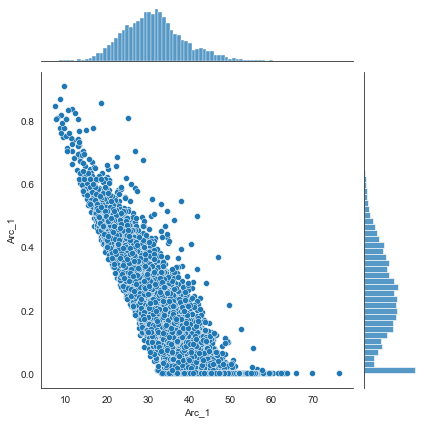

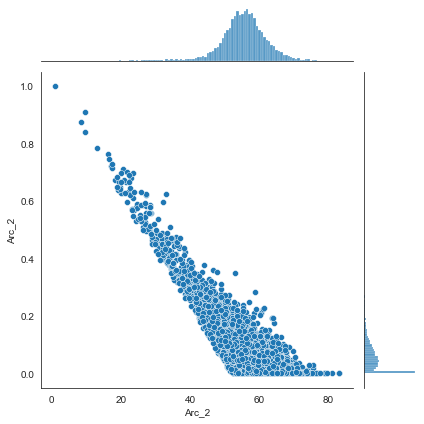

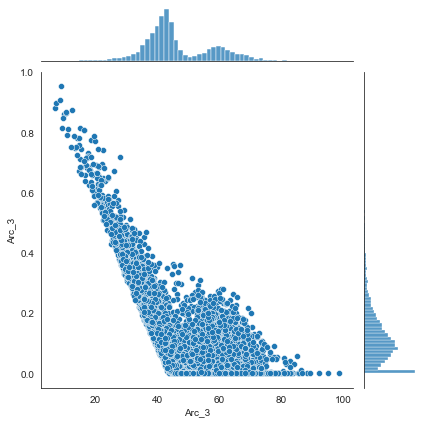

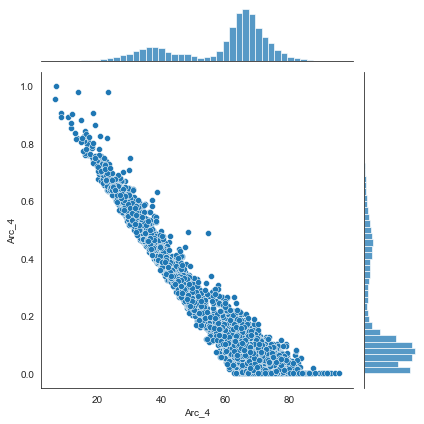

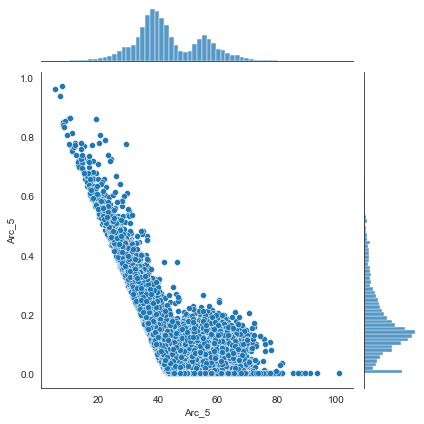

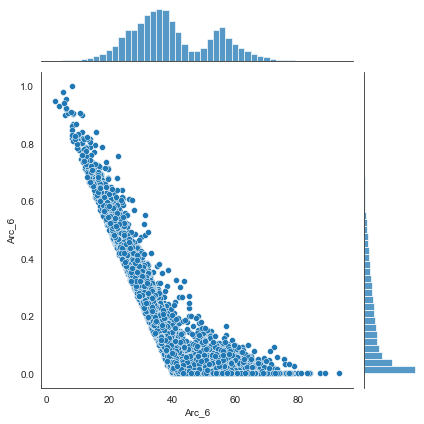

In [205]:
for c in pdx_df.T:
    sns.jointplot(pdx_df.T[c], S_df[c])


In [329]:
id_color_map = {adata.obs['identity'].unique()[i]:adata.uns['identity_colors'][i] for i in range(len(adata.uns['identity_colors']))}

In [330]:
id_color_map

{'NE_1': '#1f77b4',
 'NE_4': '#ff7f0e',
 'Club cells_1': '#279e68',
 'NE_2': '#d62728',
 'NE_3': '#aa40fc',
 'NE_7': '#8c564b',
 'Club cells_2': '#e377c2',
 'NE_6': '#b5bd61',
 'NE_8': '#17becf',
 'AT2 cells': '#aec7e8',
 'NE_10': '#ffbb78',
 'NE_5': '#98df8a',
 'NE_9': '#ff9896',
 'NE_11': '#c5b0d5'}

No handles with labels found to put in legend.


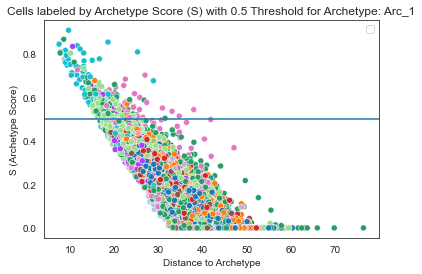

No handles with labels found to put in legend.


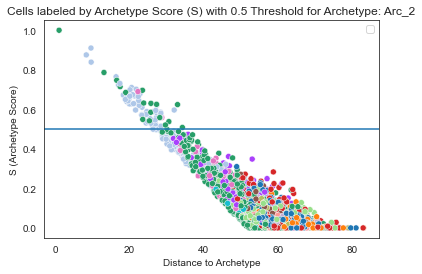

No handles with labels found to put in legend.


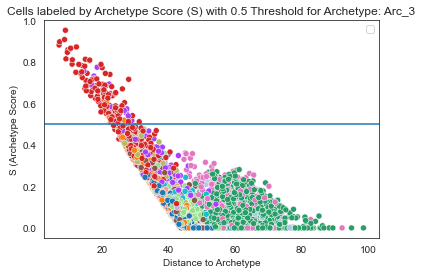

No handles with labels found to put in legend.


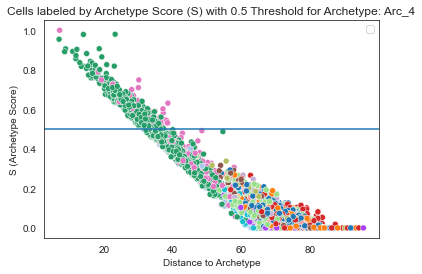

No handles with labels found to put in legend.


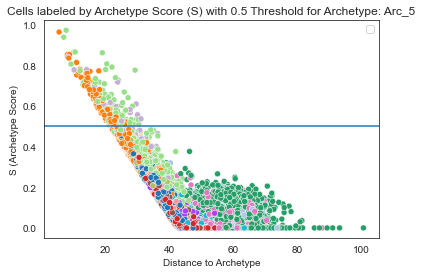

No handles with labels found to put in legend.


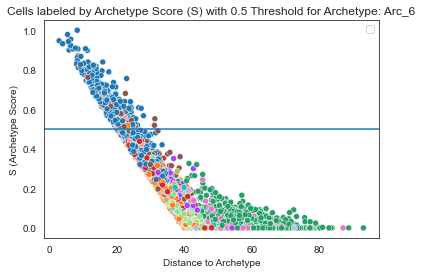

In [332]:
for c in pdx_df.T:
    sns.scatterplot(pdx_df.T[c], S_df[c], c = [id_color_map[i] for i in  adata.obs['identity']])
    plt.legend()
    plt.title("Cells labeled by Archetype Score (S) with 0.5 Threshold for Archetype: " + c)
    plt.ylabel("S (Archetype Score)")
    plt.xlabel("Distance to Archetype")
    plt.axhline(y=.5)
    plt.show()

In [333]:
S_df

Arc_1     Arc_2     Arc_3  \
CellID                                                                       
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  0.189598  0.052942  0.101080   
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  0.219531  0.028372  0.098842   
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  0.238321  0.106480  0.032418   
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  0.320185  0.038023  0.142250   
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  0.139490  0.000000  0.566935   
...                                                ...       ...       ...   
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2  0.379996  0.433019  0.114562   
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2  0.406094  0.009435  0.335363   
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2  0.067540  0.253109  0.116906   
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2  0.144225  0.025843  0.134797   
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2  0.158448  0.000000  0.017641   

                                                 Arc_4     Arc_5     Arc_6  
CellID                                                                      
gex_possorted_bam_SJSO3:AAACCGGCAGCCTAACx-M1  0.073335  0.239396  0.343649  
gex_possorted_bam_SJSO3:AAAGCCGCACCCACCTx-M1  0.008717  0.297490  0.347048  
gex_possorted_bam_SJSO3:AAACGTACAGGACCAAx-M1  0.467110  0.126746  0.028924  
gex_possorted_bam_SJSO3:AAAGGACGTAACGAGGx-M1  0.000000  0.352118  0.147424  
gex_possorted_bam_SJSO3:AAACATGCAATGAAGCx-M1  0.065554  0.036348  0.191672  
...                                                ...       ...       ...  
gex_possorted_bam_1WGCZ:TTTGTGTTCCTTAGGGx-M2  0.000000  0.072423  0.000000  
gex_possorted_bam_1WGCZ:TTTGTGGCATGGCCCAx-M2  0.020848  0.045008  0.183252  
gex_possorted_bam_1WGCZ:TTTGTGTTCGGCCATAx-M2  0.000000  0.124757  0.437688  
gex_possorted_bam_1WGCZ:TTTGTTGGTCAAAGAAx-M2  0.008790  0.415432  0.270913  
gex_possorted_bam_1WGCZ:TTTGTGAAGTAAACCCx-M2  0.040240  0.364474  0.419197  

[8908 rows x 6 columns]

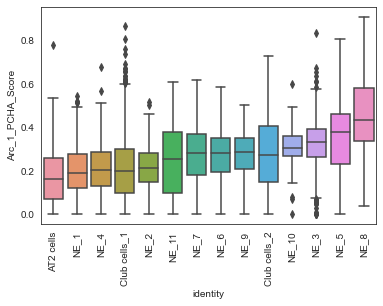

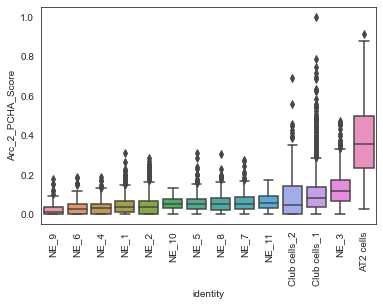

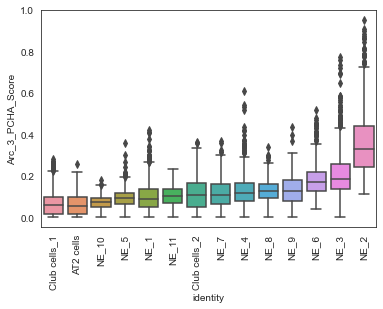

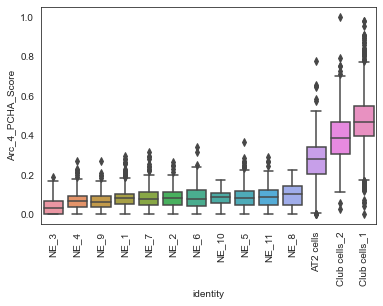

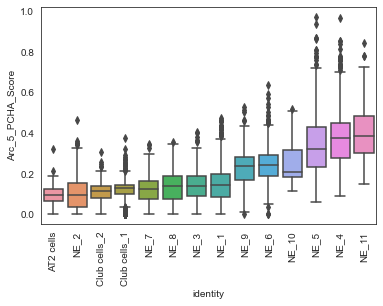

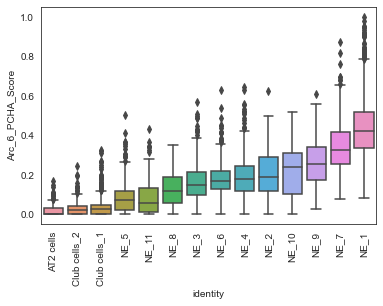

In [349]:
for arc in [str(i+1) for i in range(6)]:
    sns.boxplot(x=adata.obs.identity, y = adata.obs["Arc_"+arc+"_PCHA_Score"], order=adata.obs.groupby("identity").mean()["Arc_"+arc+"_PCHA_Score"].sort_values().index.values)
    plt.xticks(rotation = 90)
    plt.show()

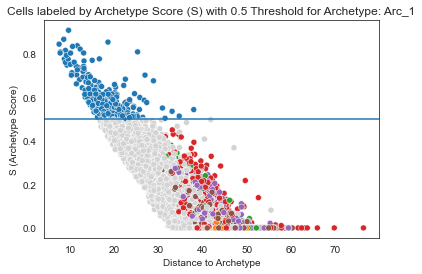

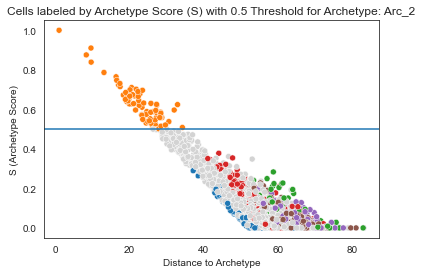

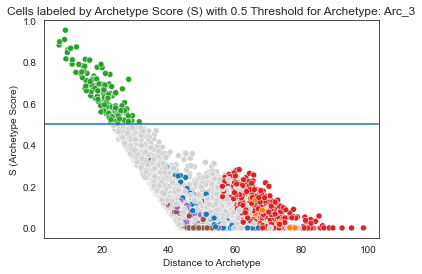

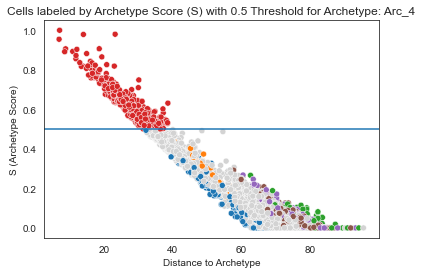

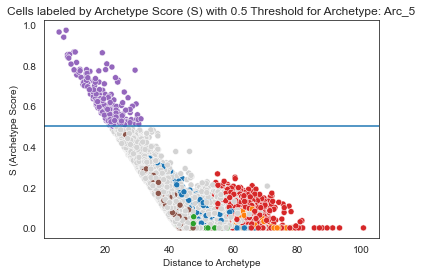

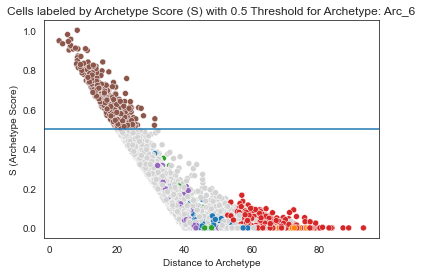

In [200]:
arc_colors = {'Arc_1':'#1f77b4', 'Arc_2':'#ff7f0e', 'Arc_3':'#2ca02c', 'Arc_4':'#d62728', 'Arc_5':'#9467bd', 'Arc_6':'#8c564b', "Generalist":"#D3D3D3"}
for c in pdx_df.T:
    sns.scatterplot(pdx_df.T[c], S_df[c], c = [arc_colors[i] for i in  adata.obs['S_0.5threshold']])
    plt.title("Cells labeled by Archetype Score (S) with 0.5 Threshold for Archetype: " + c)
    plt.ylabel("S (Archetype Score)")
    plt.xlabel("Distance to Archetype")
    plt.axhline(y=.5)
    plt.show()


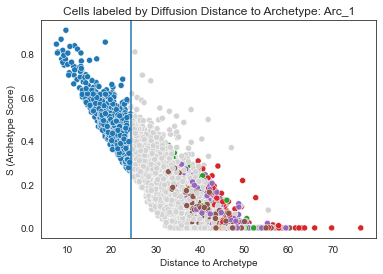

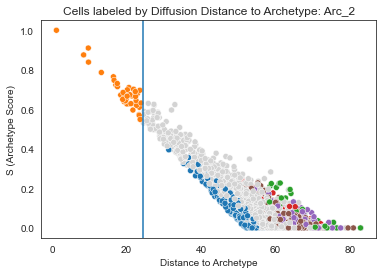

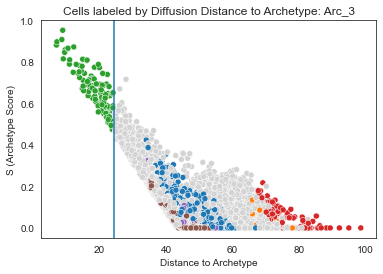

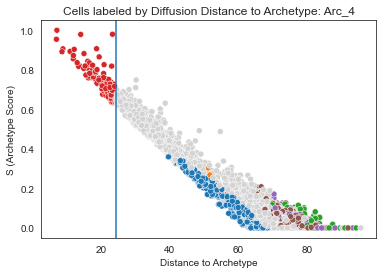

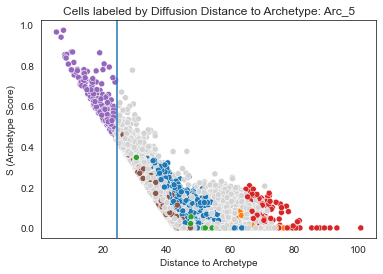

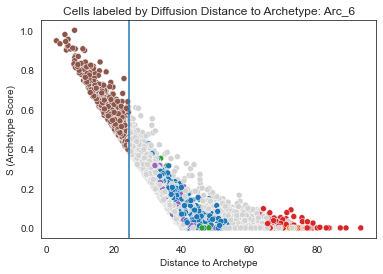

In [192]:
arc_colors = {'Arc_1':'#1f77b4', 'Arc_2':'#ff7f0e', 'Arc_3':'#2ca02c', 'Arc_4':'#d62728', 'Arc_5':'#9467bd', 'Arc_6':'#8c564b', "Generalist":"#D3D3D3"}
for c in pdx_df.T:
    sns.scatterplot(pdx_df.T[c], S_df[c], c = [arc_colors[i] if i in arc_colors.keys() else "#D3D3D3" for i in adata.obs['specialists_pca_diffdist']])
    plt.title("Cells labeled by Diffusion Distance to Archetype: " + c)
    plt.ylabel("S (Archetype Score)")
    plt.xlabel("Distance to Archetype")
    plt.axvline(x=radius)
    plt.show()


In [215]:
adata.obs = adata.obs.drop("max_arc_0.6threshold", axis = 1)

In [218]:
archetype_label = []
for i,r in adata.obs.iterrows():
    if r['specialists_pca_diffdist'] == r['S_0.5threshold']:
        archetype_label.append(r['specialists_pca_diffdist'])
    else:
        archetype_label.append("Generalist")

[<AxesSubplot:title={'center':'specialists pca diffdist'}, xlabel='umap_wnn1', ylabel='umap_wnn2'>,
 <AxesSubplot:title={'center':'S 0.5threshold'}, xlabel='umap_wnn1', ylabel='umap_wnn2'>,
 <AxesSubplot:title={'center':'archetype label'}, xlabel='umap_wnn1', ylabel='umap_wnn2'>,
 <AxesSubplot:title={'center':'identity'}, xlabel='umap_wnn1', ylabel='umap_wnn2'>]

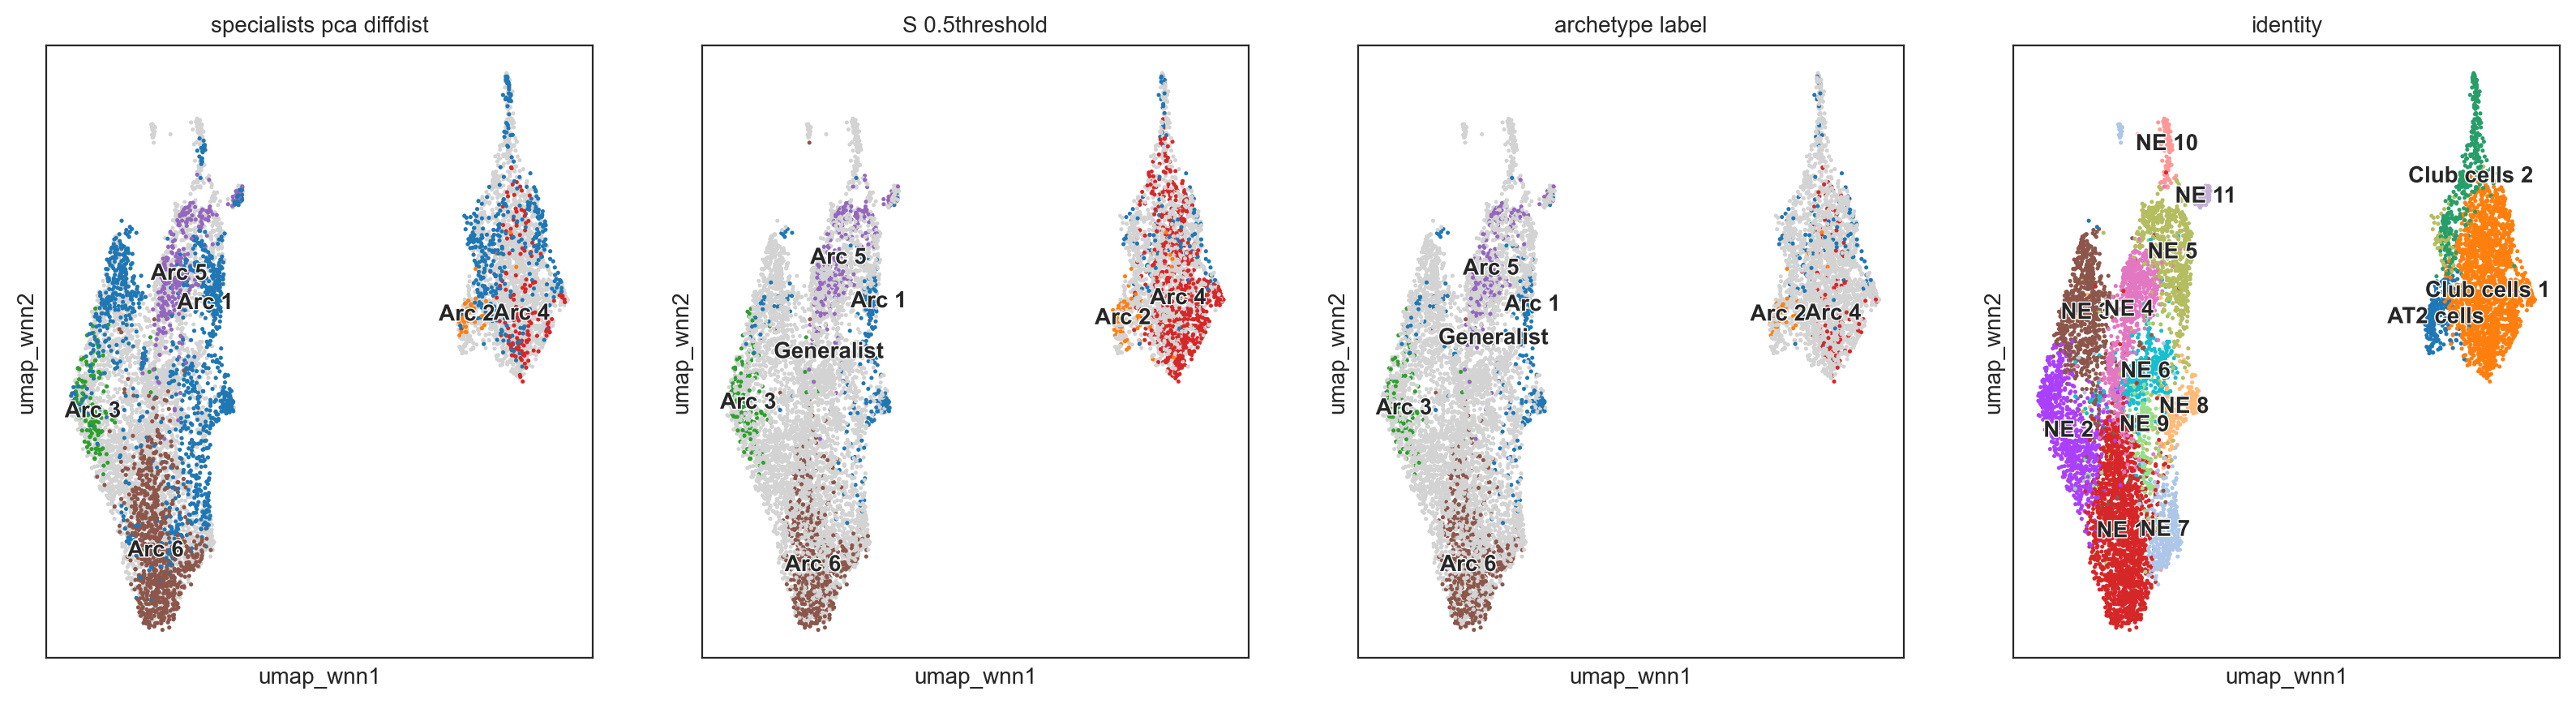

In [358]:
adata.obs['archetype_label'] = archetype_label
adata.uns['archetype_label_colors'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b','#D3D3D3']
scv.pl.scatter(adata, c = ["specialists_pca_diffdist","S_0.5threshold","archetype_label",'identity'], 
               basis = "umap_wnn",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', dpi = 200)


[<AxesSubplot:title={'center':'S 0.5threshold'}, xlabel='harmony21', ylabel='harmony22'>,
 <AxesSubplot:title={'center':'identity'}, xlabel='harmony21', ylabel='harmony22'>,
 <AxesSubplot:title={'center':'sample x'}, xlabel='harmony21', ylabel='harmony22'>]

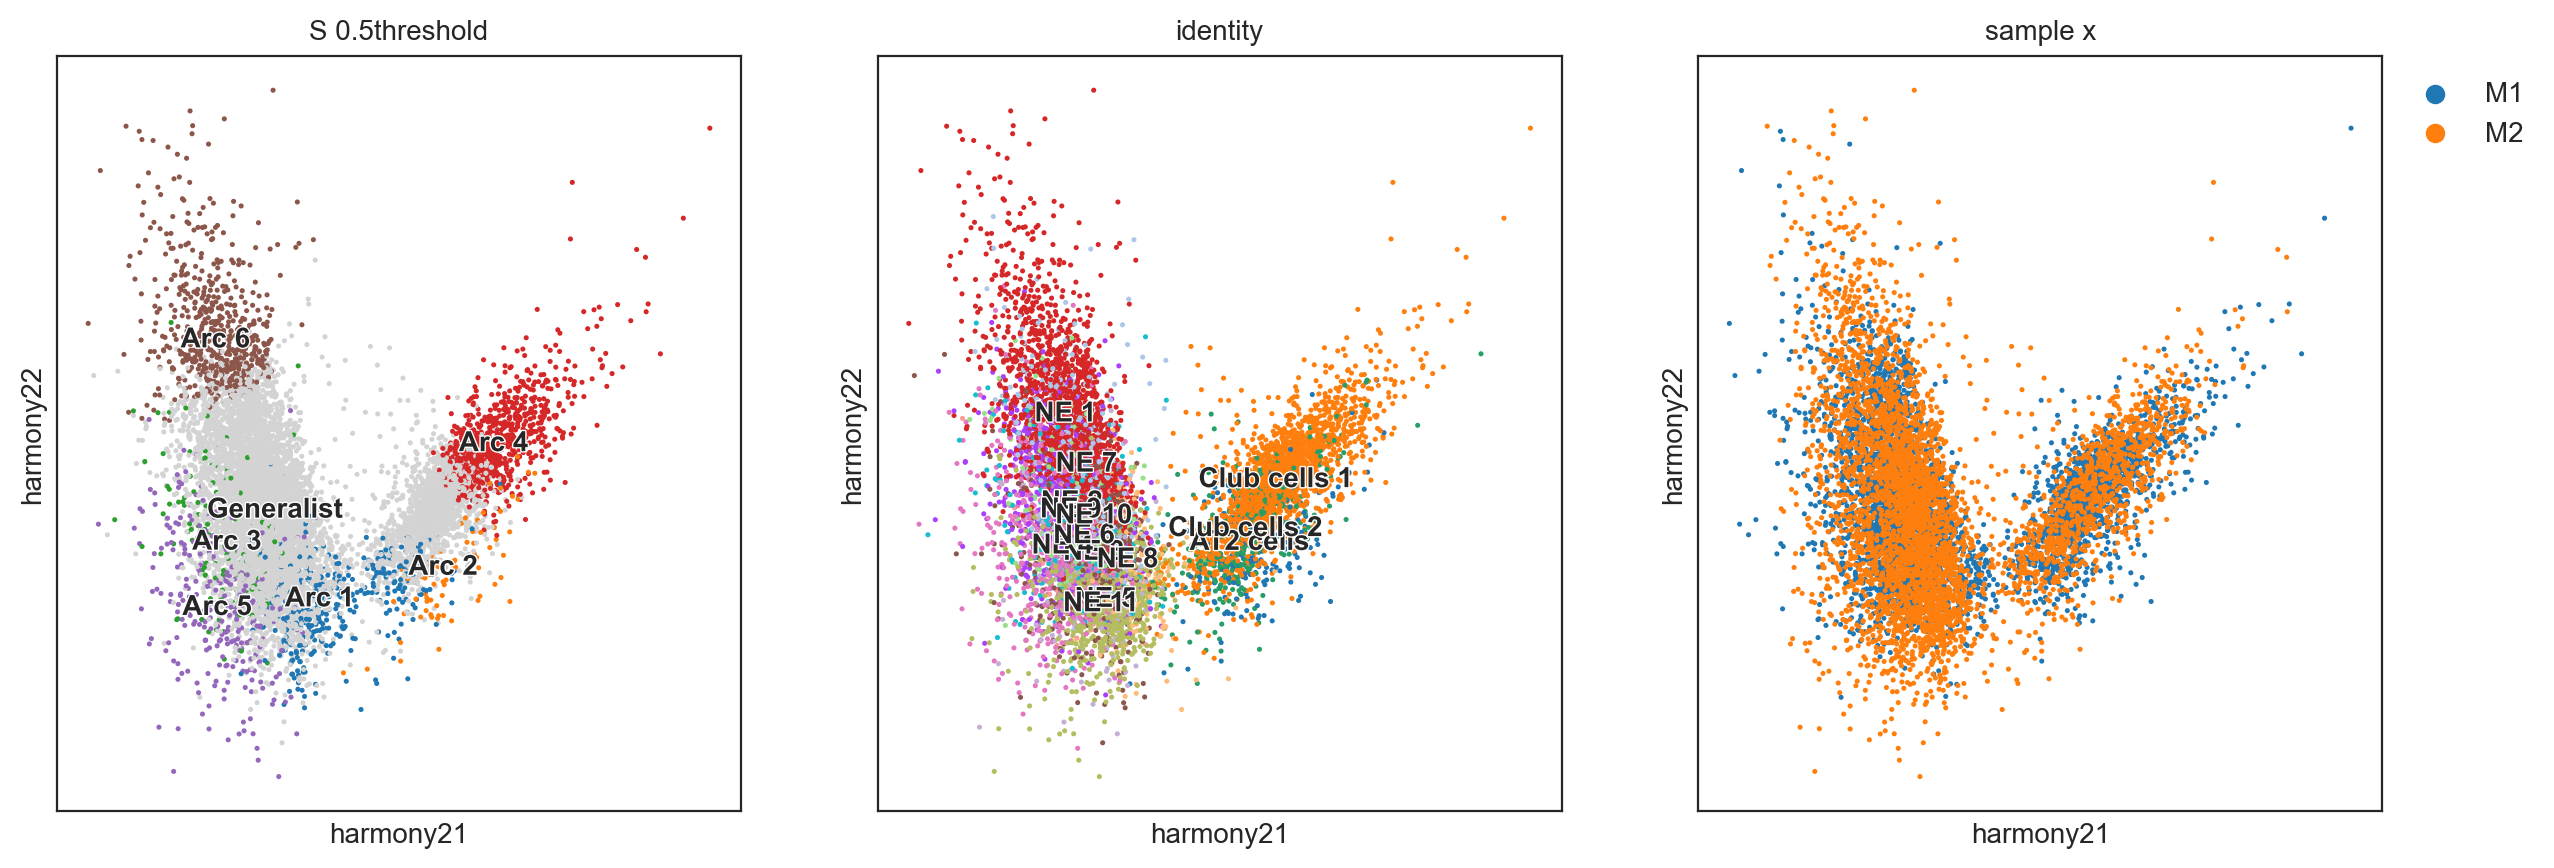

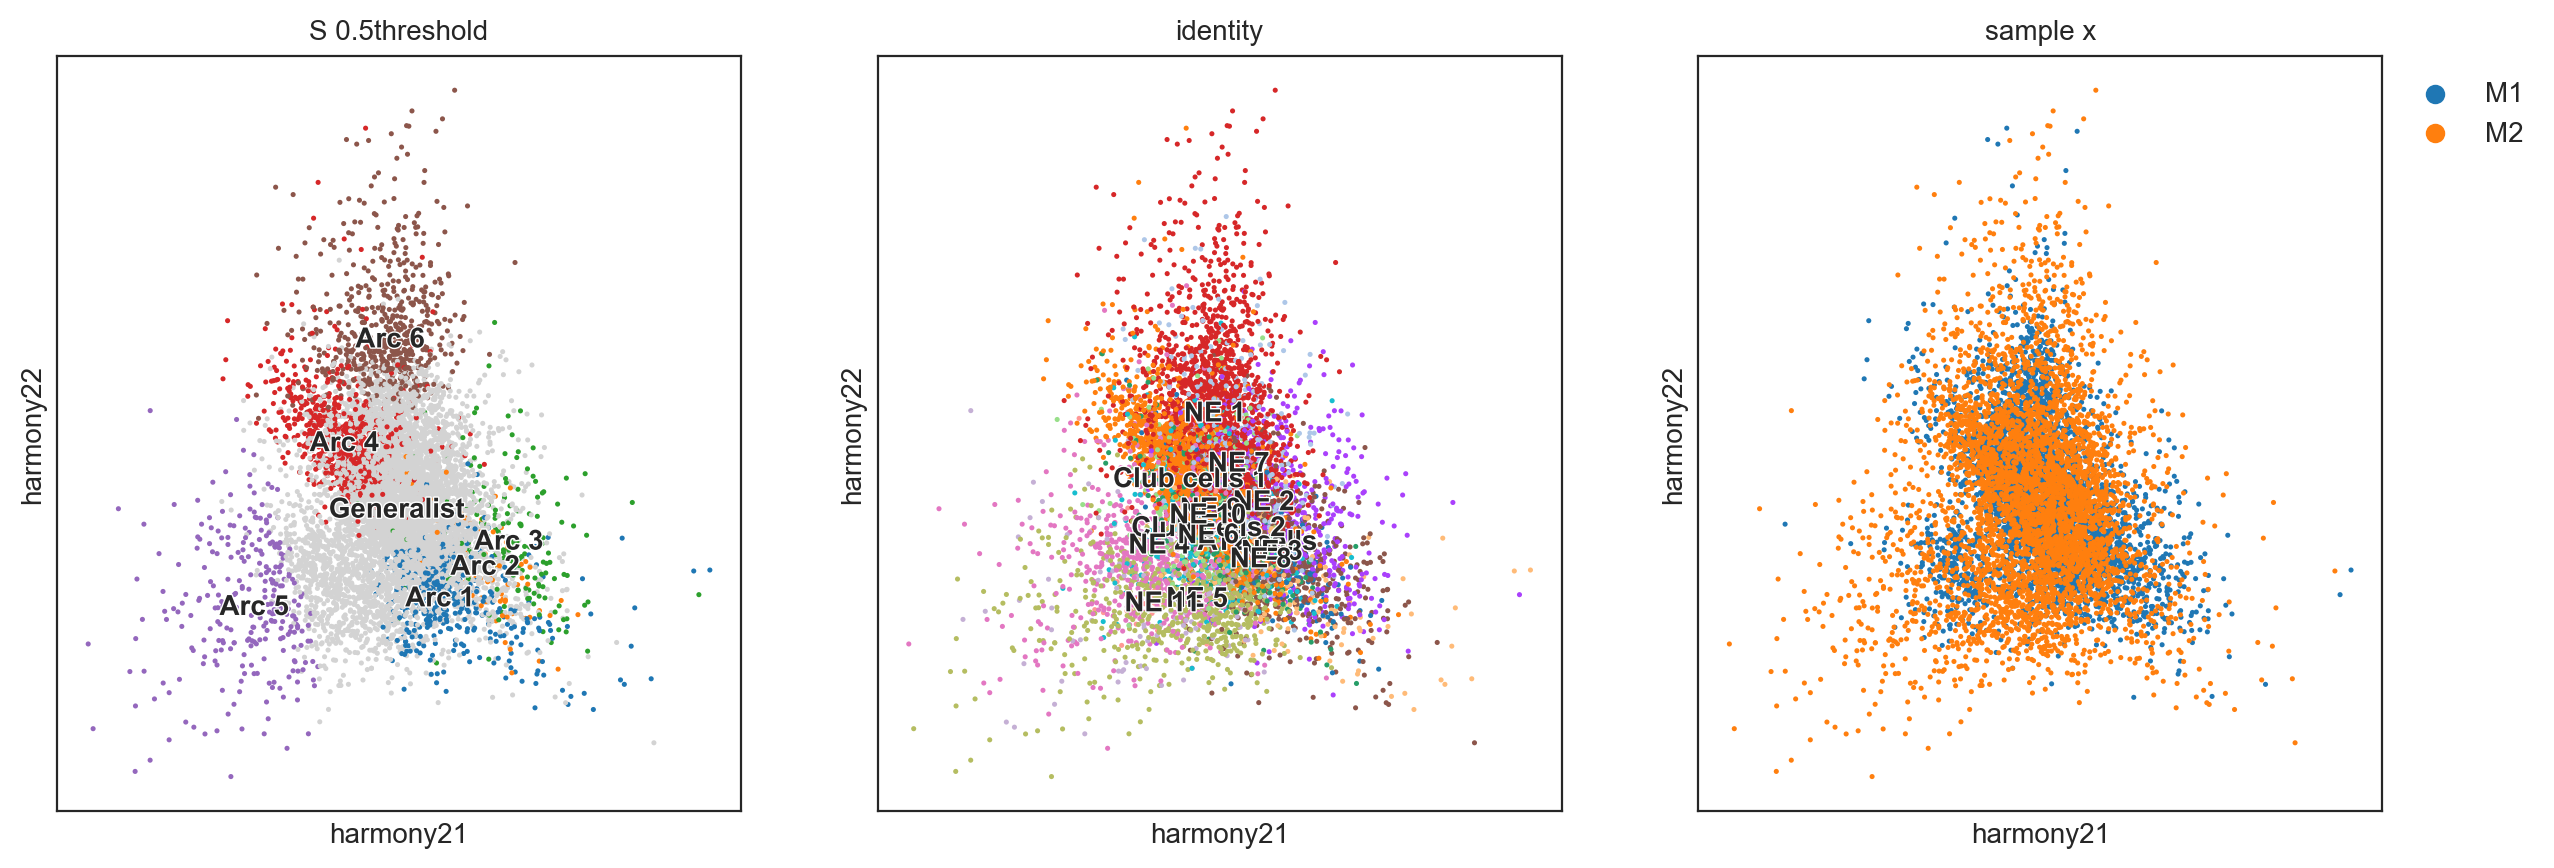

In [359]:
scv.pl.scatter(adata, c = ["S_0.5threshold",'identity','sample_x'], 
               basis = "harmony2",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', dpi = 200)
scv.pl.scatter(adata, c = ["S_0.5threshold",'identity','sample_x'], 
               basis = "harmony2",components='3,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', dpi = 200)


In [362]:
pd.crosstab(adata.obs.identity, adata.obs['S_0.5threshold']).style.background_gradient(cmap='viridis')

In [226]:
adata.write_h5ad('../../data/combined/adata_02_filtered.h5ad')

In [227]:
adata

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

# Network Preparation and EDA

## Comparison to other reductions and MAGIC imputation (for network analysis)

In [228]:
X_magic = sc.read_h5ad("../../data/combined/X_magic_02_filtered.h5ad")

In [229]:
adata.layers['imputed'] = X_magic.X
adata.obsm['X_pca_imputed'] = X_magic.obsm['X_pca']

In [230]:
adata

AnnData object with n_obs × n_vars = 8908 × 16719
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_s

[<AxesSubplot:title={'center':'S 0.5threshold'}, xlabel='pca_imputed1', ylabel='pca_imputed2'>,
 <AxesSubplot:title={'center':'identity'}, xlabel='pca_imputed1', ylabel='pca_imputed2'>,
 <AxesSubplot:title={'center':'sample x'}, xlabel='pca_imputed1', ylabel='pca_imputed2'>]

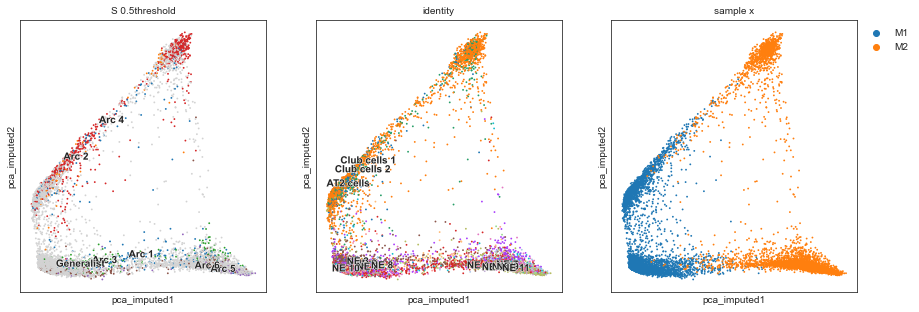

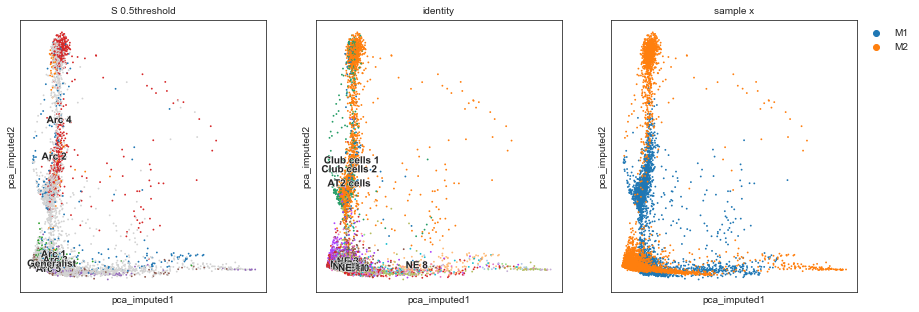

In [234]:
scv.pl.scatter(adata, c = ["S_0.5threshold",'identity','sample_x'], 
               basis = "pca_imputed",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)
scv.pl.scatter(adata, c = ["S_0.5threshold",'identity','sample_x'], 
               basis = "pca_imputed",components='3,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)


[<AxesSubplot:title={'center':'S 0.5threshold'}, xlabel='scanorama_umap1', ylabel='scanorama_umap2'>,
 <AxesSubplot:title={'center':'identity'}, xlabel='scanorama_umap1', ylabel='scanorama_umap2'>,
 <AxesSubplot:title={'center':'sample x'}, xlabel='scanorama_umap1', ylabel='scanorama_umap2'>]

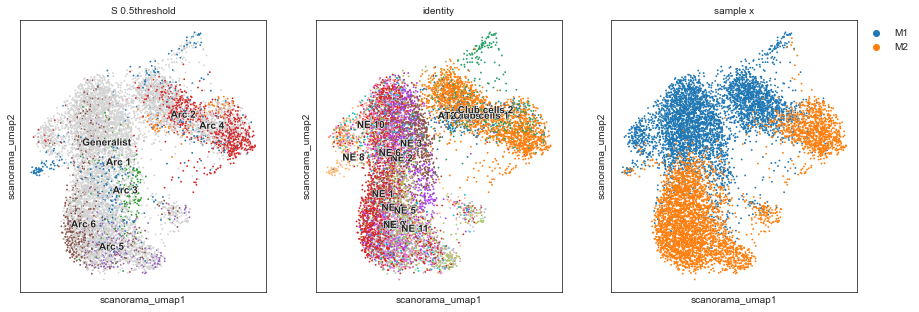

In [236]:
scv.pl.scatter(adata, c = ["S_0.5threshold",'identity','sample_x'], 
               basis = "scanorama_umap",components='1,2', show=False, figsize= (5,5), frameon=True, cmap = 'RdBu_r', smooth = True)



## Network Genes 

In [ ]:
network = pd.read_csv("../../network-inference-DIRECT-NET/networks/DIRECT-NET_network_with_FIGR_threshold_0_no_NEUROG2_top8regs_NO_sinks.csv", header = None)
network.columns = ['parent', 'child','score','evidence']
network

In [240]:
network_genes = set(network['parent']).union(set(network['child']))

In [242]:
network_genes = [i.capitalize() for i in network_genes]
network_genes

['Pknox2',
 'Zbtb18',
 'Egr1',
 'Sp100',
 'Ascl1',
 'Tcf4',
 'Stat1',
 'Six1',
 'Nfib',
 'Rarb',
 'Foxo3',
 'Runx1',
 'Meis2',
 'Creb1',
 'Junb',
 'Lmx1b',
 'Jund',
 'Kmt2a',
 'Nr3c2',
 'Cux2',
 'Nfatc2',
 'Prdm16',
 'Six4',
 'Nfkb1',
 'Rora',
 'Jun',
 'Prox1',
 'Nfia',
 'Tead1',
 'Smad3',
 'Cux1',
 'Fos',
 'Pbx1',
 'Sox9',
 'Hsf2',
 'Grhl2',
 'Pparg',
 'Ehf',
 'Rorb',
 'Esr1',
 'Zeb1',
 'Tbx15',
 'Nfix',
 'Tcf12',
 'Ets1',
 'Zbtb20',
 'Rest',
 'Tcf7l2',
 'Zbtb7a']

In [246]:
# adata_network = adata[:,network_genes].copy()

In [287]:
adata_network = X_magic[:,network_genes].copy()

In [288]:
adata_network.obsm = {}
adata_network.varm = {}

In [289]:
adata_network

AnnData object with n_obs × n_vars = 8908 × 49
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'sample_x', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'brcd', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'barcode', 'sample_y', 'ATAC_snn_res.0.5', 'seurat_clusters', 'nCount_peaks', 'nFeature_peaks', 'peaks_snn_res.0.5', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT.weight', 'peaks.weight', 'nCount_Imputed_counts', 'nFeature_Imputed_counts', 'nCount_gene_activity', 'nFeature_gene_activity', 'NE_score1', 'identity', 'non.NE_scor

In [290]:
adata_network.obs['S_0.5threshold'] = adata.obs['S_0.5threshold']

In [291]:
adata_network.uns['S_0.5threshold_colors'] = adata.uns['S_0.5threshold_colors']

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


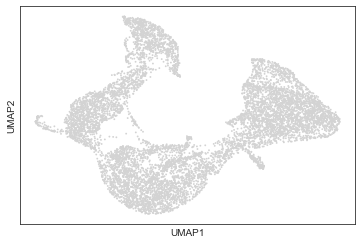

In [292]:
sc.pp.pca(adata_network, use_highly_variable=False,)
scv.pp.neighbors(adata_network, random_state=0)
scv.tl.umap(adata_network, random_state=0)
sc.pl.umap(adata_network)

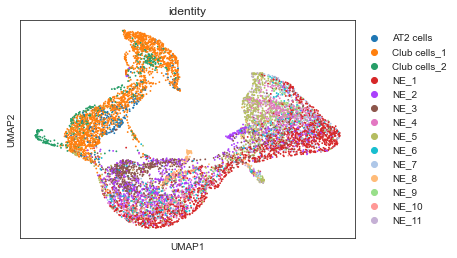

In [293]:
sc.pl.umap(adata_network, color = 'identity')

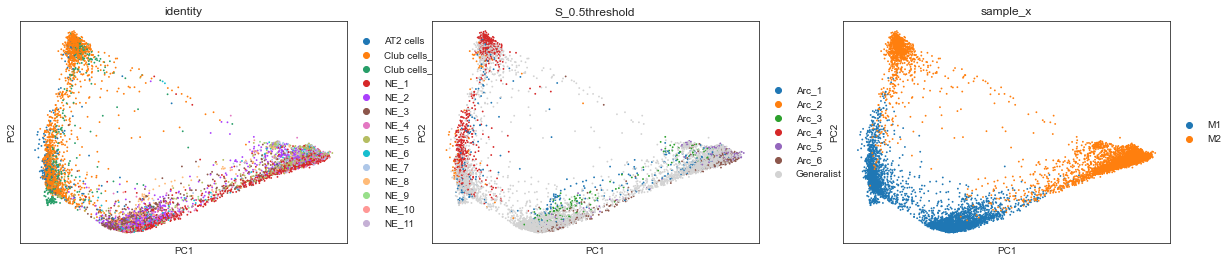

In [294]:
sc.pl.pca(adata_network, color = ['identity','S_0.5threshold','sample_x'])

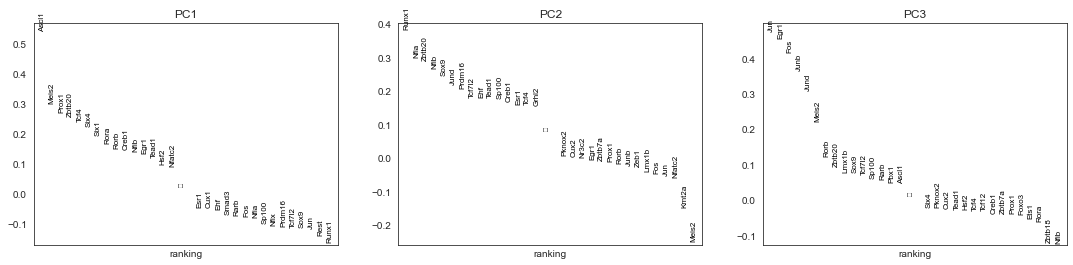

In [295]:
sc.pl.pca_loadings(adata_network)

# Ranking genes

In [282]:
sc.tl.rank_genes_groups(adata, groupby='S_0.5threshold')

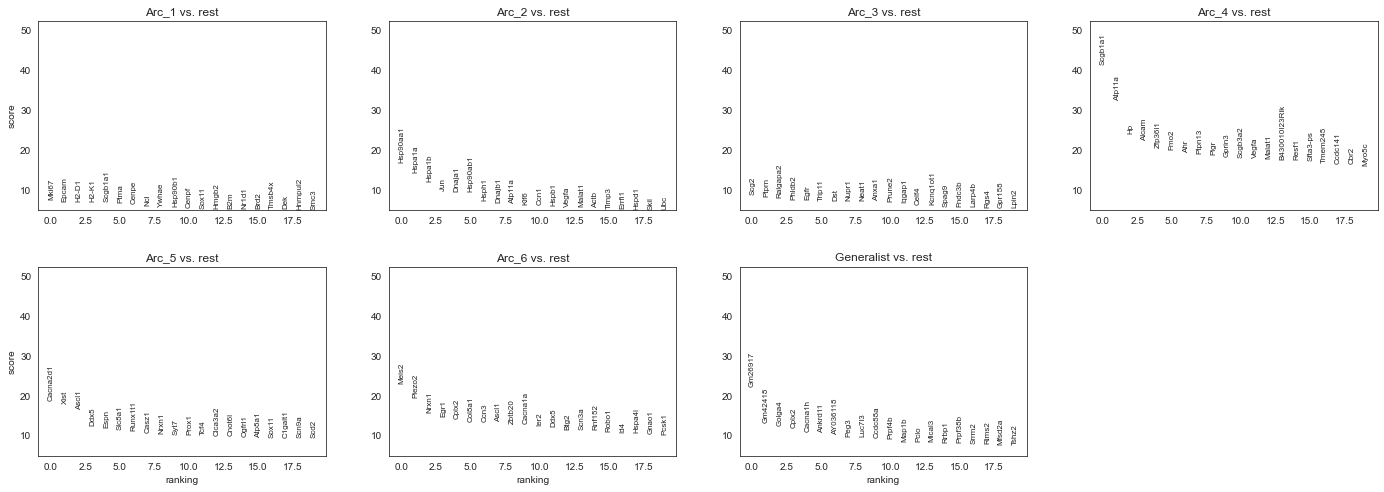

In [387]:
sc.pl.rank_genes_groups(adata, dpi = 300)

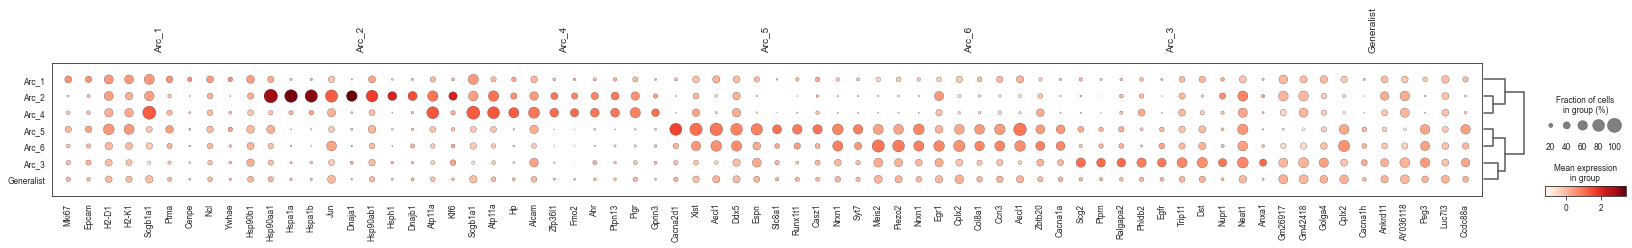

In [389]:
sc.pl.rank_genes_groups_dotplot(adata)

In [284]:
adata.write_h5ad("../../data/combined/adata_02_filtered.h5ad")

In [285]:
adata_network.write_h5ad("../../data/combined/adata_network_02_filtered.h5ad")

In [300]:
adata.uns['rank_genes_groups']['names']

rec.array([('Mki67', 'Hsp90aa1', 'Scg2', 'Scgb1a1', 'Cacna2d1', 'Meis2', 'Gm26917'),
           ('Epcam', 'Hspa1a', 'Ptprn', 'Atp11a', 'Xist', 'Piezo2', 'Gm42418'),
           ('H2-D1', 'Hspa1b', 'Ralgapa2', 'Hp', 'Ascl1', 'Nrxn1', 'Golga4'),
           ...,
           ('Adamtsl2', 'Slc8a1', 'Serpine2', 'Peg3', 'Fmo2', 'B430010I23Rik', 'Hp'),
           ('Ccdc24', 'Syne1', 'Cnpy1', 'Piezo2', 'Gm26917', 'Myo5c', 'Atp11a'),
           ('Meis2', 'Vwf', 'Fmo2', 'Meis2', 'Gm42418', 'Zfp36l1', 'Scgb1a1')],
          dtype=[('Arc_1', 'O'), ('Arc_2', 'O'), ('Arc_3', 'O'), ('Arc_4', 'O'), ('Arc_5', 'O'), ('Arc_6', 'O'), ('Generalist', 'O')])

In [305]:
sc.tl.rank_genes_groups(adata, 'S_0.5threshold', method='wilcoxon', key_added = "wilcoxon")


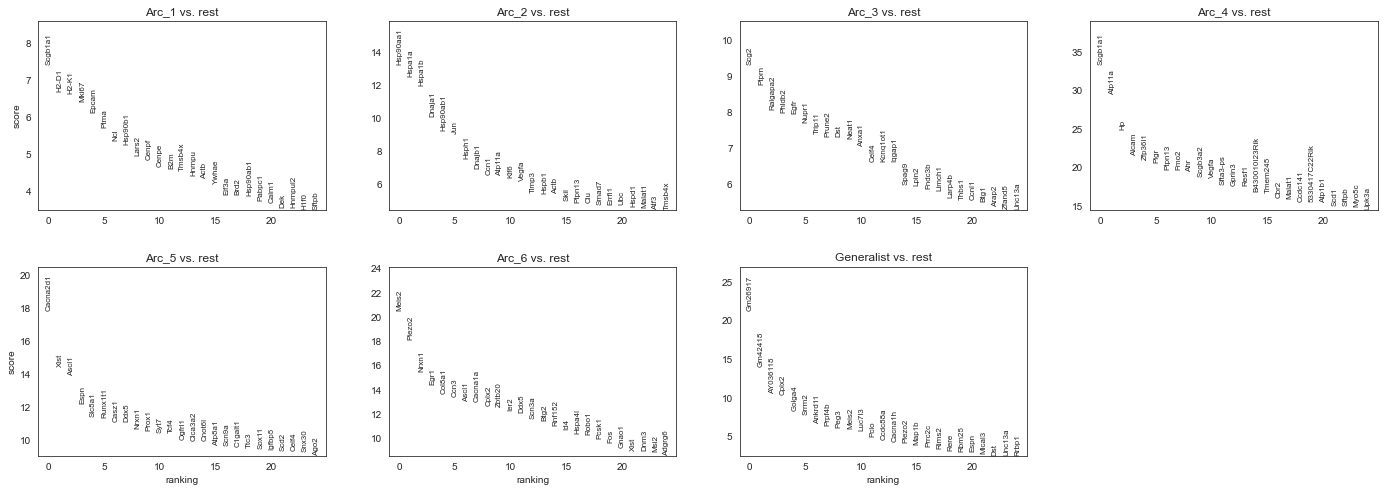

In [306]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon", dpi = 200)

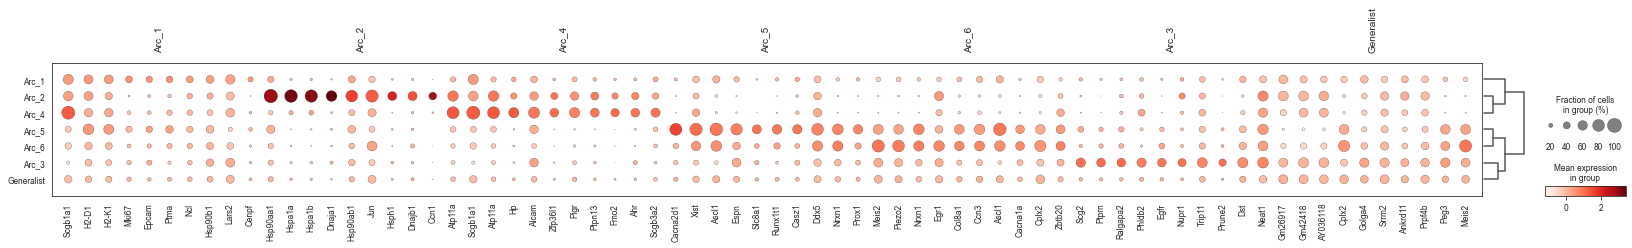

In [400]:
sc.pl.rank_genes_groups_dotplot(adata, key = 'wilcoxon')

## GSEA

In [ ]:
#!pip install gseapy

In [302]:
import gseapy


In [303]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Mouse')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

19


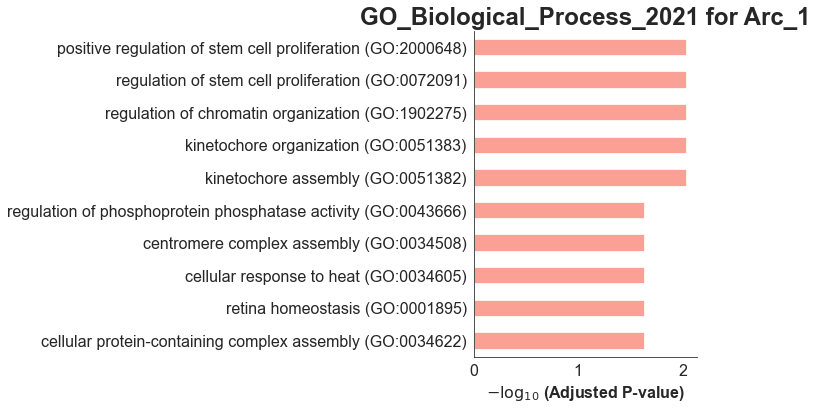

35


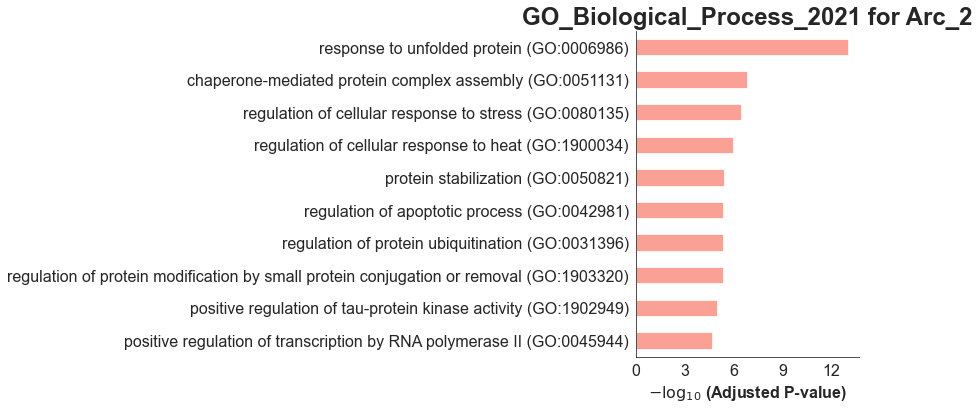

82


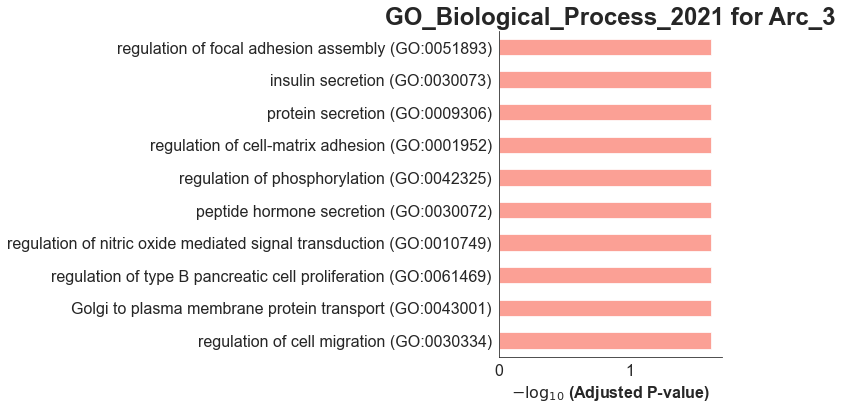

691


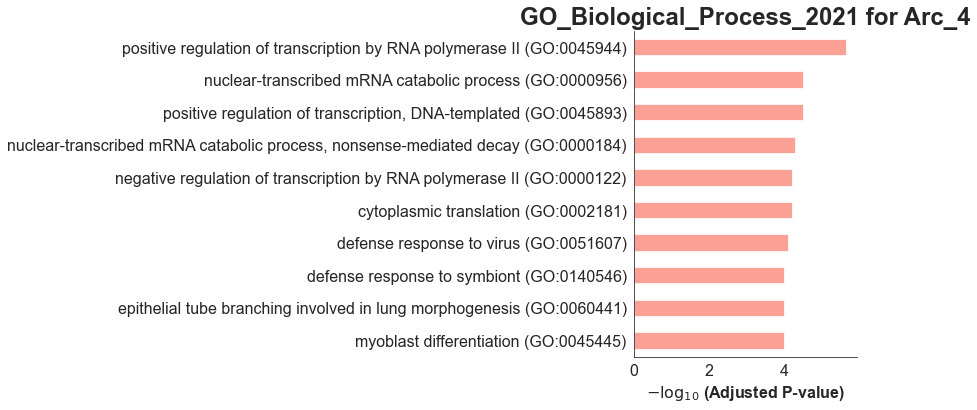

637


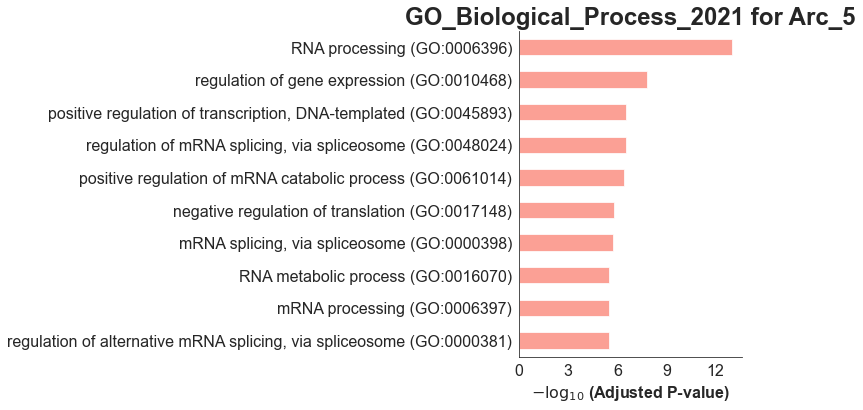

252


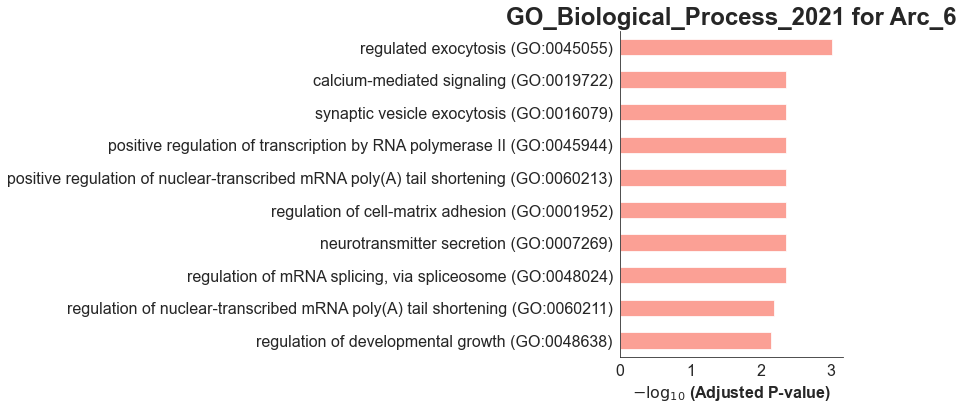

In [370]:
for arc in ['Arc_'+str(i+1) for i in range(6)]:
    glist = sc.get.rank_genes_groups_df(adata, group=arc, 
                                        key='wilcoxon', 
                                        pval_cutoff=0.05)
    glist = glist.loc[glist['scores']>0]['names'].squeeze().str.strip().tolist()
    print(len(glist))

    enr_res = gseapy.enrichr(gene_list=glist,
                         organism='Mouse',
                         gene_sets='GO_Biological_Process_2021',
                         cutoff = 0.5)

    gseapy.barplot(enr_res.res2d,title=f'GO_Biological_Process_2021 for {arc}')
    plt.show()

In [378]:
arc_1 = sc.get.rank_genes_groups_df(adata, group='Arc_1', 
                                        key='wilcoxon', 
                                        pval_cutoff=0.05)

In [379]:
arc_genes = pd.DataFrame(columns=arc_1.columns)
for arc in ['Arc_'+str(i+1) for i in range(6)]:
    tmp = sc.get.rank_genes_groups_df(adata, group=arc, 
                                        key='wilcoxon', 
                                        pval_cutoff=0.05)
    tmp['archetype'] = arc
    arc_genes = pd.concat([arc_genes, tmp])

In [399]:
arc_genes.loc[arc_genes['scores'] > 6].to_csv("top_DEG_archetypes.csv")